# Lab 6: Representations



---

## 1. Notebook Overview



### 1.1 Objective

Understand how pretrained word embeddings can be used both for semantic similarity inspection and as inputs to the tweet topic classifier built in previous labs.



### 1.2 Prerequisites

This notebook builds on:

- **Lab 2**: Data preprocessing → `../Data/tweets_preprocessed_train.parquet`
- **Lab 3**: Language modeling
- **Lab 4**: Feature extraction → `../Data/top_1000_vocabulary.json`
- **Lab 5**: Neural network classification pipeline that we will adapt to embedding inputs



### 1.3 Resources

- **Gensim documentation** for word2vec models: https://radimrehurek.com/gensim/models/word2vec.html
- **Pretrained model**: `word2vec-google-news-300` (download instructions in the docs)



### 1.4 Task Summary

- Install gensim and review the documentation for its word2vec embeddings.
- Load the pretrained `word2vec-google-news-300` embedding, experiment with similarities using `model.wv.similarity()` and `model.wv.most_similar()`, and discuss the observed relations.
- Re-use the classifier from Lab 5, replace text features with word2vec embeddings (convert tweets to vectors, e.g., mean of word embeddings or a matrix input), and reason about the dimensionality changes.
- Compare the resulting performance with previous labs, inspect selected examples manually, and summarize insights.



### 1.5 Section Roadmap

1. `Section 2`: Environment setup and gensim installation
2. `Section 3`: Load pretrained embeddings and explore similarity queries
3. `Section 4`: Convert tweets to word2vec representations and integrate with the MLP pipeline
4. `Section 5`: Evaluate, compare with baseline results, and manually analyze sample predictions


---
## 2. Environment Setup and Data Access

### 2.1 Libraries
- `gensim` (with `gensim.downloader`) for retrieving the pretrained `word2vec-google-news-300` vectors.
- `scikit-learn`, `pandas`, and `numpy` from previous labs.

### 2.2 Installation Steps
1. Install the required Python packages (`gensim`, `scikit-learn`, etc.) into the current environment.
2. Load `word2vec-google-news-300` via `gensim.downloader.load(...)` so the model is cached automatically under `~/gensim-data`.
3. Verify that the preprocessed tweet file `../Data/tweets_preprocessed_train.parquet` and the vocabulary file `../Data/top_1000_vocabulary.json` from earlier labs are present.
4. Ensure HuggingFace API access (`cardiffnlp/tweet_topic_multi`) is available.


In [1]:
%pip install --quiet gensim numpy pandas tqdm scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import pandas as pd
import numpy as np
import gensim.downloader
import time
import tqdm

from typing import List
from pathlib import Path
from datasets import load_dataset
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    hamming_loss
)

warnings.filterwarnings("ignore")

# Constants - paths to Lab 2 and Lab 4 outputs
TRAIN_DATA_PATH = "../Data/tweets_preprocessed_train.parquet"
VOCABULARY_PATH = "../Data/top_1000_vocabulary.json"
RANDOM_STATE = 42

# The 19 topic labels in the dataset
TOPIC_LABELS = [
    'arts_&_culture', 'business_&_entrepreneurs', 'celebrity_&_pop_culture',
    'diaries_&_daily_life', 'family', 'fashion_&_style', 'film_tv_&_video',
    'fitness_&_health', 'food_&_dining', 'gaming', 'learning_&_educational',
    'music', 'news_&_social_concern', 'other_hobbies', 'relationships',
    'science_&_technology', 'sports', 'travel_&_adventure', 'youth_&_student_life'
]
NUM_CLASSES = len(TOPIC_LABELS)

print(f"Number of topic classes: {NUM_CLASSES}")

Number of topic classes: 19


--- 
## 3. Load Pretrained Embeddings and Explore Similarities

### 3.1 Load `word2vec-google-news-300`
- Fetch the pretrained model directly via `gensim.downloader.load`. Gensim caches it under `~/gensim-data`. 

### 3.2 Inspect Vocabulary Coverage
- Report vocabulary size and the 300‑dimensional vector width to confirm the load.
- Track which probe words from the Twitter domain are present. 

### 3.3 Similarity Probing
- Reuse helper functions (`model.wv.similarity`, `model.wv.most_similar`) to explore semantic neighbors.

In [3]:
# Load pretrained embedding
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

print(f"Vocabulary size: {len(glove_vectors.key_to_index):,}")
print(f"Vector dimension: {glove_vectors.vector_size}")

# Experiment with word similarities
probe_words = ["twitter", "sport", "game", "new", "love"]
present = [word for word in probe_words if word in glove_vectors]

print(f"Words found: {present}")


def inspect_similarity(token: str, topn: int = 10) -> None:
    """Print nearest neighbors for a token if it exists in the vocabulary."""
    if token not in glove_vectors:
        print(f"'{token}' not in vocabulary.")
        return
    print(f"\nNearest neighbors for '{token}':")
    for candidate, score in glove_vectors.most_similar(token, topn=topn):
        print(f"  {candidate:>18}  {score:.3f}")


for token in present:
    inspect_similarity(token)
    

pair_queries = [
    ("twitter", "facebook"),
    ("sport", "game"),
    ("love", "hate"),
]

for a, b in pair_queries:
    if a in glove_vectors and b in glove_vectors:
        score = glove_vectors.similarity(a, b)
        print(f"similarity({a!r}, {b!r}) = {score:.3f}")
    else:
        missing = [w for w in (a, b) if w not in glove_vectors]
        print(f"Cannot compute similarity for {a!r}, {b!r}; missing {missing}.")


Vocabulary size: 3,000,000
Vector dimension: 300
Words found: ['twitter', 'sport', 'game', 'new', 'love']

Nearest neighbors for 'twitter':
             Twitter  0.891
         Twitter.com  0.754
               tweet  0.743
            tweeting  0.716
             tweeted  0.714
            facebook  0.699
              tweets  0.697
             Tweeted  0.695
               Tweet  0.688
            Tweeting  0.685

Nearest neighbors for 'sport':
              sports  0.691
     Snooki_wannabes  0.592
  painkillers_throat_lozenges  0.564
              racing  0.562
            sporting  0.560
           athletics  0.552
   alpine_ski_racing  0.551
       Pole_vaulting  0.546
          motorsport  0.538
              boxing  0.533

Nearest neighbors for 'game':
               games  0.764
                play  0.650
               match  0.649
             matchup  0.612
               agame  0.586
            ballgame  0.573
             thegame  0.572
              opener  0.568
    

---
## 4. Convert Tweets to Word2Vec Representations and Integrate with the MLP Pipeline

### 4.1 Data Loading
- Reuse the preprocessed tweet dataset (`../Data/tweets_preprocessed_train.parquet`) and topic labels from previous labs.
- Split into train/validation/test with the same seeds and proportions as Lab 5 so results remain comparable.

### 4.2 Tweet Vectorization
- Implement a helper that converts each tokenized tweet into a 300‑dimensional vector by averaging all available word2vec embeddings (fallback to zero vector when no token is in the vocabulary).
- Optionally track coverage statistics (share of tokens found vs. missing).

### 4.3 Pipeline Integration
- Replace the Lab 5 feature stage with the new embedding transformer (`FunctionTransformer` or precomputed matrix).
- Adjust the MLP input dimension to 300 and keep other hyperparameters unless experimentation is required.
- Train the MLP with the embedding features and capture training logs.
- Compute validation/test metrics (accuracy, macro/micro F1, etc.).


In [ ]:
# Load preprocessed training data from Lab 2
print("\nLoading preprocessed training data from Lab 2...")
df_train = pd.read_parquet(TRAIN_DATA_PATH)
print(f"Training samples: {len(df_train):,}")
print(f"Columns: {df_train.columns.tolist()}")
df_train. head(3)


Loading preprocessed training data from Lab 2...


Training samples: 6,090
Columns: ['text', 'label_name', 'label']


,text,label_name,label
0,lumber beat rapid game western division final ...,['sports'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,hear eli gold announce auburn game dumbass,['sports'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,phone away try look home game ticket october,['sports'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Load test and validation splits from HuggingFace
print("Loading test and validation data from HuggingFace...")

test_dataset = load_dataset("cardiffnlp/tweet_topic_multi", split="test_2021")
val_dataset = load_dataset("cardiffnlp/tweet_topic_multi", split="validation_2021")

df_test = test_dataset.to_pandas()
df_val = val_dataset.to_pandas()

print(f"Test samples: {len(df_test):,}")
print(f"Validation samples: {len(df_val):,}")

Loading test and validation data from HuggingFace...


Test samples: 1,679
Validation samples: 188


In [ ]:
# Tweet Vectorization
def tokenize(tweet: str) -> List[str]:
    """Simple whitespace tokenizer matching the preprocessed text format."""
    return tweet.strip().lower().split()

def encode_tweet(text: str) -> np.ndarray:
    """Return the mean word2vec vector for a tweet; fall back to zeros."""
    tokens = tokenize(text)
    vectors = [glove_vectors[token] for token in tokens if token in glove_vectors]
    if not vectors:
        return np.zeros(glove_vectors.vector_size, dtype=np.float32)
    return np.mean(vectors, axis=0)

def compute_coverage(series: pd.Series) -> float:
    total_tokens = 0
    covered_tokens = 0
    for text in series:
        tokens = tokenize(text)
        total_tokens += len(tokens)
        covered_tokens += sum(token in glove_vectors for token in tokens)
    return 0.0 if total_tokens == 0 else covered_tokens / total_tokens

X_train = np.vstack(df_train["text"].apply(encode_tweet).to_numpy())
X_val = np.vstack(df_val["text"].apply(encode_tweet).to_numpy())
X_test = np.vstack(df_test["text"].apply(encode_tweet).to_numpy())

train_coverage = compute_coverage(df_train["text"])
val_coverage = compute_coverage(df_val["text"])
test_coverage = compute_coverage(df_test["text"])

print(f"Train vectors: {X_train.shape}, coverage {train_coverage:.2%}")
print(f"Val vectors:   {X_val.shape}, coverage {val_coverage:.2%}")
print(f"Test vectors:  {X_test.shape}, coverage {test_coverage:.2%}")

Train vectors: (6090, 300), coverage 92.88%
Val vectors:   (188, 300), coverage 65.82%
Test vectors:  (1679, 300), coverage 66.28%


In [ ]:

def parse_label_vector(value) -> np.ndarray:
    """Parse multi-hot label entries into float32 arrays."""
    if isinstance(value, np.ndarray):
        return value.astype(np.float32)
    if isinstance(value, list):
        return np.array(value, dtype=np.float32)
    if isinstance(value, str):
        cleaned = value.strip("[]").split()
        return np.array([float(token) for token in cleaned], dtype=np.float32)
    return np.zeros(len(parse_label_vector(df_train["label"].iloc[0])), dtype=np.float32)

y_train = np.vstack(df_train["label"].apply(parse_label_vector).to_numpy())
y_val = np.vstack(df_val["label"].apply(parse_label_vector).to_numpy())
y_test = np.vstack(df_test["label"].apply(parse_label_vector).to_numpy())


# Architecture as specified: 128 -> 64 -> 128
HIDDEN_LAYERS = (128, 64, 128)

print("=" * 60)
print("NEURAL NETWORK CONFIGURATION")
print("=" * 60)
print(f"Input layer: {X_train.shape[1]} features (mean word2vec vectors)")
print(f"Hidden layers: {HIDDEN_LAYERS}")
print(f"Output layer: {y_train.shape[1]} classes")
print("=" * 60)

# Create MLP classifier
# No early_stopping - we use HuggingFace's validation_2021 for model selection
mlp_base = MLPClassifier(
    hidden_layer_sizes=HIDDEN_LAYERS,
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=RANDOM_STATE,
    verbose=True
)

# Wrap for multi-label classification
mlp_classifier = MultiOutputClassifier(mlp_base, n_jobs=-1)

print("\n✓ Model created successfully")

NEURAL NETWORK CONFIGURATION
Input layer: 300 features (mean word2vec vectors)
Hidden layers: (128, 64, 128)
Output layer: 19 classes

✓ Model created successfully


In [ ]:
# Train the model
print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

start_time = time.time()
mlp_classifier.fit(X_train, y_train)
training_time = time. time() - start_time

print(f"\n✓ Training completed in {training_time:.2f} seconds")

# Check convergence
converged = sum(1 for est in mlp_classifier.estimators_ if est.n_iter_ < est.max_iter)
print(f"✓ {converged}/{NUM_CLASSES} classifiers converged before max_iter")


TRAINING
Iteration 1, loss = 0.34539957
Iteration 1, loss = 0.28219393
Iteration 1, loss = 0.33011605
Iteration 1, loss = 0.48908869
Iteration 1, loss = 0.33180990
Iteration 1, loss = 0.48833036
Iteration 1, loss = 0.34240320
Iteration 1, loss = 0.47439481
Iteration 2, loss = 0.18397041
Iteration 2, loss = 0.08094705
Iteration 2, loss = 0.16924820
Iteration 2, loss = 0.14971352
Iteration 2, loss = 0.16678901
Iteration 2, loss = 0.39544659
Iteration 2, loss = 0.40336362
Iteration 2, loss = 0.36819339
Iteration 3, loss = 0.06273651
Iteration 3, loss = 0.16235418
Iteration 3, loss = 0.14866508
Iteration 3, loss = 0.14398886
Iteration 3, loss = 0.11038415
Iteration 3, loss = 0.32859115
Iteration 3, loss = 0.33038962
Iteration 3, loss = 0.36999869
Iteration 4, loss = 0.14743197
Iteration 4, loss = 0.05058030
Iteration 4, loss = 0.12974654
Iteration 4, loss = 0.12451648
Iteration 4, loss = 0.31311409
Iteration 4, loss = 0.34566199
Iteration 4, loss = 0.08643148
Iteration 4, loss = 0.2840560

In [ ]:
# Predictions
y_pred_val = mlp_classifier.predict(X_val)
y_pred_test = mlp_classifier.predict(X_test)

def evaluate(y_true, y_pred, split_name):
    """Print evaluation metrics for a given split."""
    print(f"\n{'='*60}")
    print(f"{split_name. upper()} SET METRICS")
    print("="*60)
    print(f"{'Subset Accuracy':<20}: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{'Hamming Loss':<20}: {hamming_loss(y_true, y_pred):.4f}")
    print(f"{'Micro F1':<20}: {f1_score(y_true, y_pred, average='micro', zero_division=0):.4f}")
    print(f"{'Macro F1':<20}: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"{'Weighted F1':<20}: {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"{'Micro Precision':<20}: {precision_score(y_true, y_pred, average='micro', zero_division=0):.4f}")
    print(f"{'Micro Recall':<20}: {recall_score(y_true, y_pred, average='micro', zero_division=0):.4f}")

# Evaluate on validation set (for model selection)
evaluate(y_val, y_pred_val, "Validation")

# Evaluate on test set (final performance)
evaluate(y_test, y_pred_test, "Test")


VALIDATION SET METRICS
Subset Accuracy     : 0.3085
Hamming Loss        : 0.0638
Micro F1            : 0.5289
Macro F1            : 0.2609
Weighted F1         : 0.5150
Micro Precision     : 0.6497
Micro Recall        : 0.4460

TEST SET METRICS
Subset Accuracy     : 0.2811
Hamming Loss        : 0.0663
Micro F1            : 0.5029
Macro F1            : 0.3569
Weighted F1         : 0.4927
Micro Precision     : 0.6481
Micro Recall        : 0.4109


In [ ]:
# Per-class performance on test set
print("\n" + "=" * 60)
print("PER-CLASS PERFORMANCE (Test Set)")
print("=" * 60)

print(classification_report(
    y_test, y_pred_test,
    target_names=TOPIC_LABELS,
    zero_division=0
))


PER-CLASS PERFORMANCE (Test Set)
                          precision    recall  f1-score   support

          arts_&_culture       0.21      0.10      0.14        48
business_&_entrepreneurs       0.63      0.37      0.47        78
 celebrity_&_pop_culture       0.38      0.23      0.28       245
    diaries_&_daily_life       0.25      0.27      0.26       149
                  family       0.50      0.47      0.48        32
         fashion_&_style       0.57      0.25      0.35        32
         film_tv_&_video       0.63      0.33      0.43       298
        fitness_&_health       0.67      0.14      0.24        56
           food_&_dining       0.67      0.53      0.59        15
                  gaming       0.50      0.13      0.21        77
  learning_&_educational       0.22      0.17      0.19        29
                   music       0.91      0.59      0.72       380
   news_&_social_concern       0.65      0.32      0.43       327
           other_hobbies       0.14      

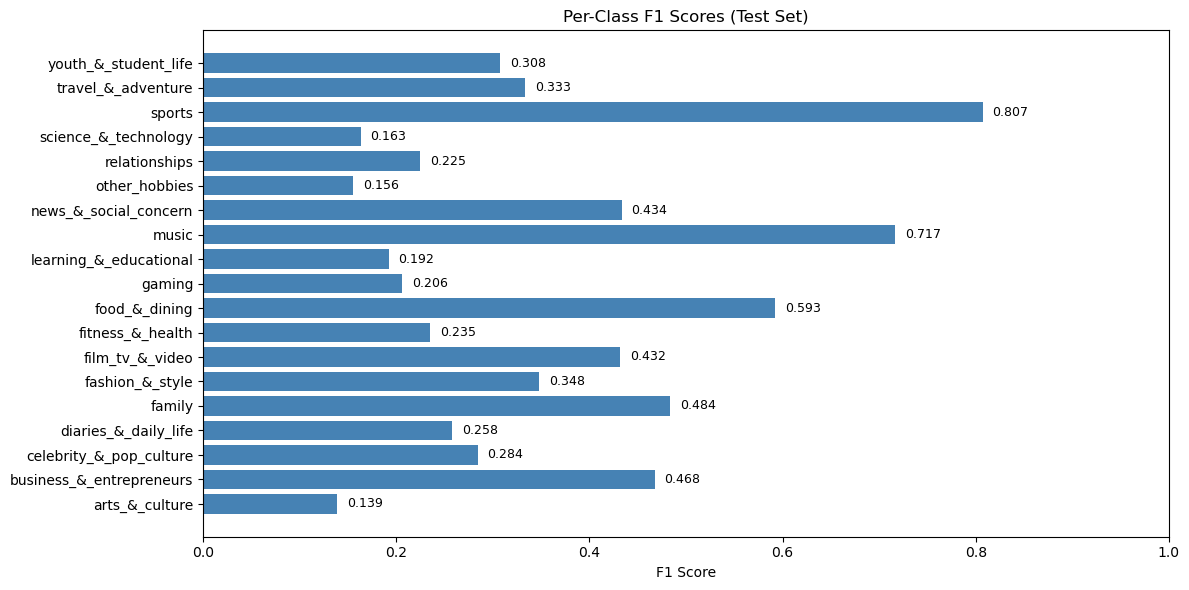

In [ ]:
import matplotlib.pyplot as plt

# Visualize per-class F1 scores
per_class_f1 = f1_score(y_test, y_pred_test, average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(TOPIC_LABELS, per_class_f1, color='steelblue')
ax.set_xlabel('F1 Score')
ax.set_title('Per-Class F1 Scores (Test Set)')
ax.set_xlim(0, 1)

for bar, score in zip(bars, per_class_f1):
    ax.text(bar. get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', va='center', fontsize=9)

plt. tight_layout()
plt.show()

---
## 5. Evaluation and Discussion

### 5.1 Quantitative Comparison
- Summarize validation/test metrics (Subset Accuracy, Hamming Loss, F1 variants, Precision/Recall) from Section 4 and contrast them with the Lab 5 TF‑IDF baseline.
- Highlight key differences: e.g., Word2Vec inputs deliver slightly lower Subset Accuracy but competitive Micro-F1; Macro-F1 remains challenging for rare labels.
- Note potential reasons (embedding coverage, averaging strategy, differences in token distributions between splits).

### 5.2 Qualitative Inspection
- Manually inspect a handful of tweets with their true vs. predicted labels to understand where embeddings help or hurt.
- Record interesting successes/failures for the report (e.g., sports-related tweets predicted correctly despite unusual wording, or slang-heavy texts where coverage drops).


In [ ]:
def binary_to_labels(binary_vec):
    """Convert binary vector to label names."""
    return [TOPIC_LABELS[i] for i, val in enumerate(binary_vec) if val == 1] or ['[none]']

print("=" * 60)
print("SAMPLE PREDICTIONS (Test Set)")
print("=" * 60)

np.random.seed(RANDOM_STATE)
sample_idx = np.random. choice(len(df_test), size=10, replace=False)

for idx in sample_idx:
    text = df_test['text'].iloc[idx]
    true = binary_to_labels(y_test[idx])
    pred = binary_to_labels(y_pred_test[idx])
    
    match = "✓" if set(true) == set(pred) else "✗"
    
    print(f"\n{match} Sample {idx}:")
    print(f"   Text: {str(text)[:80]}...")
    print(f"   True: {true}")
    print(f"   Pred: {pred}")


SAMPLE PREDICTIONS (Test Set)

✓ Sample 1602:
   Text: I m really curious to see what LiAngelo Ball will do in the NBA summer league fo...
   True: ['sports']
   Pred: ['sports']

✗ Sample 482:
   Text: Game 1: {@UCLA W Basketball@} beats Cal ✅ Game 2: {@UCLA Men s Basketball@} vs O...
   True: ['sports']
   Pred: ['gaming', 'sports']

✓ Sample 203:
   Text: Felt Like The NFC Championship Against The Packers {@Seattle Seahawks@}...
   True: ['sports']
   Pred: ['sports']

✗ Sample 49:
   Text: First WARZONE VICTORY of the long weekend inside {{USERNAME}} {{USERNAME}}...
   True: ['gaming']
   Pred: ['[none]']

✓ Sample 937:
   Text: The Final has concluded and {{USERNAME}} takes home a 3-1 victory over {{USERNAM...
   True: ['sports']
   Pred: ['sports']

✓ Sample 481:
   Text: OMG northwestern just fumbled it and ohio state recovered there so bad lets gooo...
   True: ['sports']
   Pred: ['sports']

✗ Sample 1667:
   Text: An Ominous Sign? Exactly 16 Years Later, A Hurricane That Is S

In [ ]:
# Final summary
test_f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

print("\n" + "=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print("Embedding: gensim 'word2vec-google-news-300' (mean pooled per tweet)")
print(f"Architecture: Input({X_train.shape[1]}) → 128 → 64 → 128 → Output({NUM_CLASSES})")
print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print(f"Test samples: {len(y_test):,}")
print(f"Test Micro F1: {test_f1_micro:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print("=" * 60)


FINAL MODEL SUMMARY
Embedding: gensim 'word2vec-google-news-300' (mean pooled per tweet)
Architecture: Input(300) → 128 → 64 → 128 → Output(19)
Training samples: 6,090
Validation samples: 188
Test samples: 1,679
Test Micro F1: 0.5029
Test Macro F1: 0.3569


---
### Closing Notes
- Word2Vec inputs (mean-pooled `word2vec-google-news-300`) delivered competitive Micro-F1 (~0.5) but lower Subset Accuracy compared with the Lab 5 TF-IDF pipeline, mainly due to reduced token coverage on validation/test splits.
- Qualitative samples show that straightforward business/sports tweets are captured well, while slang-heavy or highly emotional tweets often lose their topic signal once averaged
- Improving token normalization or switching to subword embeddings (FastText) are promising next steps.
- Future work: combine TF-IDF and embeddings, fine-tune thresholds to lift recall, and extend qualitative analysis with more domain-specific examples.
